In [1]:
from sqlalchemy import create_engine
import pymssql
import pandas as pd
import numpy as np

import joblib

In [3]:
server = "mssql-82792-0.cloudclusters.net:16272"
username = "user"
password = "RiceOwls1912" 
database = "ghz"
string = "mssql+pymssql://" + username + ":" + password + "@" + server + "/" + database

conn = create_engine(string).connect()

# Get data

In [4]:
df = pd.read_sql(
    """
    select date, ticker, bm, mom12m, roeq, siccd, mve, ret
    from data
    order by date, ticker
    """,
    conn
  )
df = df.dropna()
features = ["roeq", "bm", "mom12m"]

## Add industry variable to dataframe


In [5]:
inds = pd.read_csv("siccodes12.csv", index_col="industry")
ind_names = inds.index.unique().to_list()

def industry(sic):
  try:
    return inds[(inds.start<=sic)&(sic<=inds.end)].index[0]
  except:
    return "Other"
    
codes = pd.Series({code: industry(code) for code in df.siccd.unique()})
codes.name = "industry" 
codes.index.name = "siccd"
df = df.merge(codes, on="siccd")
features.append("industry")
df = df.set_index(["date", "ticker"])

# Load pipeline

In [6]:
pipe = joblib.load('./my_pipe.joblib')

# Train your pipeline

In [7]:
dates = ["2005-01", "2010-01", "2015-01", "2020-01", "3000-01"]
predictions = None
for train_date, end_date in zip(dates[:-1], dates[1:]):
  fltr1 = df.index.get_level_values("date") < train_date
  fltr2 = df.index.get_level_values("date") < end_date
  train = df[fltr1]
  test = df[~fltr1 & fltr2]
  Xtrain = train[features]
  ytrain = train["ret"]
  Xtest = test[features]
  ytest = test["ret"]
  pipe.fit(Xtrain, ytrain)
  pred = pipe.predict(Xtest)
  print('Train set score: ' + str(pipe.score(Xtrain, ytrain)))
  pred = pd.Series(pred, index=test.index)
  print('Test set score: ' + str(pipe.score(Xtest,ytest)))
  predictions = pd.concat((predictions, pred))
df["predict"] = predictions

Train set score: 0.0018397830687515437
Test set score: -0.03771984076328616
Train set score: 0.0015095398819710004
Test set score: -0.003032162228824964
Train set score: 0.0010679342558366223
Test set score: -0.0025529646214537127
Train set score: 0.0007950480844848284
Test set score: -0.002602179054176812


In [13]:
joblib.dump(pipe, 'my_pipe.joblib')

['my_pipe.joblib']

# Rank - Equal weights

In [8]:
numlong = 100
numshort = 100

df["rank_from_top"] = df.groupby("date").predict.rank(
  method="first", 
  ascending=False
)
df["long"] = df.rank_from_top <= numlong

df["rank_from_bottom"] = df.groupby("date").predict.rank(
  method="first"
)
df["short"] = df.rank_from_bottom <= numshort

# Monthly returns

In [10]:
df = df[df.index.get_level_values("date") >= dates[0]]

long_ret = df.groupby("date").apply(
    lambda d: (d.long*d.ret).mean()
)
short_ret = df.groupby("date").apply(
    lambda d: (d.short*d.ret).mean()
)

# 150/50 Portfolio

In [11]:
ret = 1.5*long_ret - 0.5*short_ret
ret

date
2005-01   -0.000052
2005-02    0.001312
2005-03   -0.001356
2005-04   -0.001577
2005-05    0.001407
             ...   
2021-11   -0.004192
2021-12   -0.000970
2022-01   -0.003420
2022-02   -0.001193
2022-03    0.001354
Length: 207, dtype: float64

<AxesSubplot:xlabel='date'>

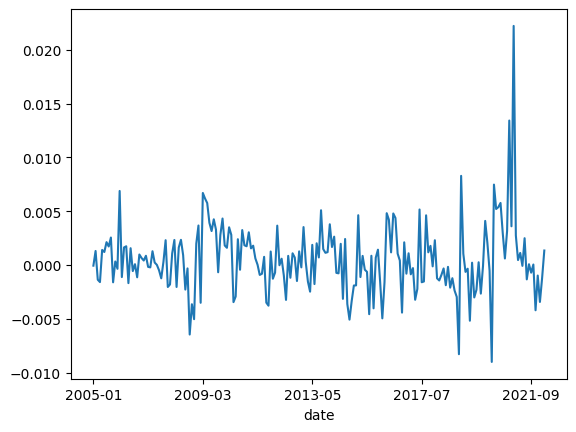

In [12]:
ret.plot()